# Condensed Nearest Neighbours (CNN)

[Machine Learning with Imbalanced Data - Course]

The algorithms works as follows:

1) Put all minority class observations in a group, typically group O

2) Add 1 sample (at random) from the majority class to group O

3) Train a KNN with group O

4) Take a sample of the majority class that is not in group O yet

5) Predict its class with the KNN from point 3

6) If the prediction was correct, go to 4 and repeat

7) If the prediction was incorrect, add that sample to group O, go to 3 and repeat

8) Continue until all samples of the majority class were either assigned to O or left out

9) Final version of Group O is our undersampled dataset


====

- **Criteria for data exclusion**: Samples outside the boundary between the classes
- **Final Dataset size**: varies

====

This algorithm tends to pick points near the fuzzy boundary between the classes, and transfer those to the group O, in our example.

If the classes are similar, group O will contain a fair amount of both classes. If the classes are very different, group O would contain mostly 1 class, the minority class.

**Caution:**

- CNN tends to add noise to the undersampled dataset
- Computationally expensive, because it trains 1 KNN every time an observation is added to the minority class group.

In this notebook, we will first understand what Condensed Nearest Neigbours is doing with simulated data, and then compare its effect on model performance with real data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import CondensedNearestNeighbour

## Create data

We will create data where the classes have different degrees of separateness.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [2]:
def make_data(sep):

    # returns arrays
    X, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           class_sep=sep,# how separate the classes are
                           random_state=1)

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns =['varA', 'varB'])
    y = pd.Series(y)

    return X, y

0    983
1     17
Name: count, dtype: int64


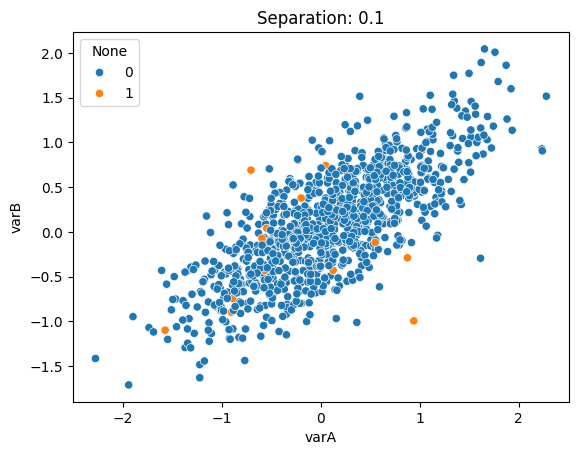

0    983
1     17
Name: count, dtype: int64


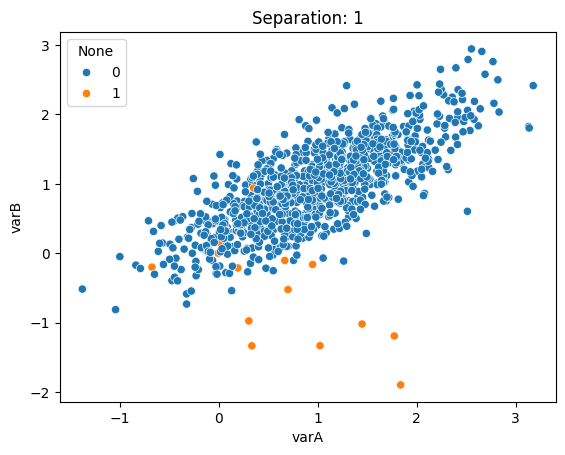

0    983
1     17
Name: count, dtype: int64


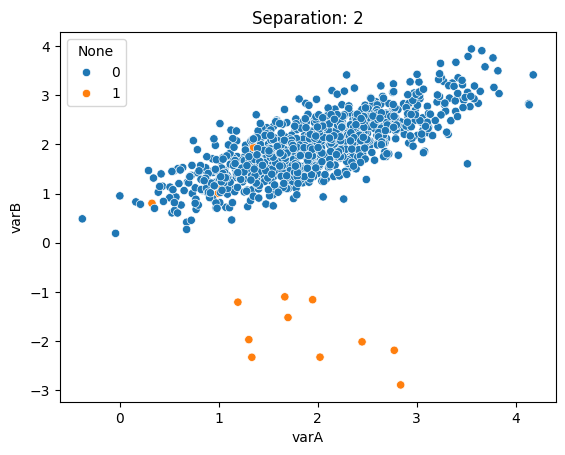

In [3]:
# make datasets with different class separateness
# and plot

for sep in [0.1, 1, 2]:

    X, y = make_data(sep)

    print(y.value_counts())

    sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

    plt.title('Separation: {}'.format(sep))
    plt.show()

## Undersample with Condensed Nearest Neighbours


[CondensedNearestNeighbour](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.CondensedNearestNeighbour.html)


### Well separated classes

In [29]:
# create data

X, y = make_data(sep=2)

# set up condensed nearest neighbour transformer

cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,  # for reproducibility
    n_neighbors=1,# default
    n_jobs=4)  # I have 4 cores in my laptop

X_resampled, y_resampled = cnn.fit_resample(X, y)

In [25]:
# size of original data

X.shape, y.shape

((1000, 2), (1000,))

In [30]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((70, 2), (70,))

In [31]:
# number of minority class observations

y.value_counts()

0    983
1     17
Name: count, dtype: int64

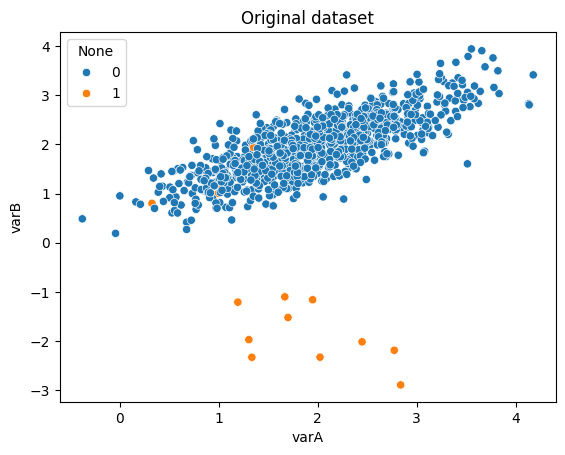

In [32]:
sns.scatterplot(
    data=X, x="varA", y="varB", hue=y
)

plt.title('Original dataset')
plt.show()

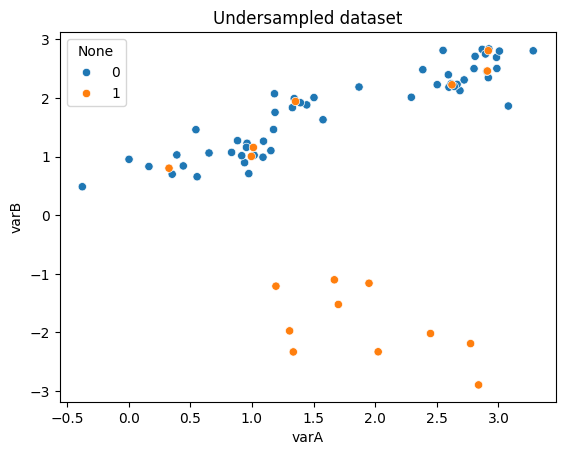

In [33]:
# plot undersampled data

sns.scatterplot(
    data=X_resampled, x="varA", y="varB", hue=y_resampled
)

plt.title('Undersampled dataset')
plt.show()

Condensed Nearest Neighbours retains the observations from the majority class, that are more similar to those in the minority class.

**Note how values bigger where varA > 3, and varB >3 have not been included in the undersampled dataset**

### Partially separated classes

In [10]:
# create data
X, y = make_data(sep=0.5)

# set up condensed nearest neighbour transformer

cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,  # for reproducibility
    n_neighbors=1,
    n_jobs=4)  # I have 4 cores in my laptop

X_resampled, y_resampled = cnn.fit_resample(X, y)

In [11]:
# original data

X.shape, y.shape

((1000, 2), (1000,))

In [12]:
# undersampled data

X_resampled.shape, y_resampled.shape

((101, 2), (101,))

Note that more samples were included in the final training set, compared to the previous case where classes were more separated.

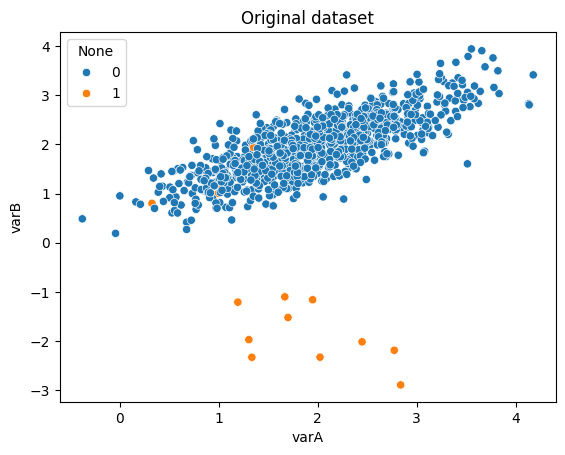

In [34]:
sns.scatterplot(
    data=X, x="varA", y="varB", hue=y
)

plt.title('Original dataset')
plt.show()

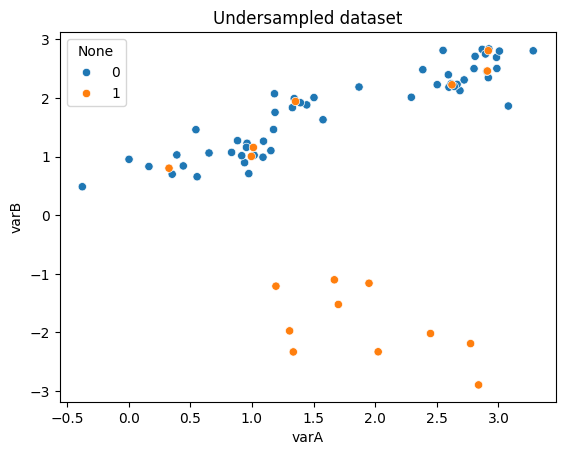

In [35]:
# plot undersampled data

sns.scatterplot(
    data=X_resampled, x="varA", y="varB", hue=y_resampled
)

plt.title('Undersampled dataset')
plt.show()

Note again, how CNN preserves the observations from the majority class that look more similar to those in the minority class.

**HOMEWORK**

- Although CNN was originally developed using 1 KNN, try changing the number of neighbours and compare the sizes of the undersampled datasets and the distribution of the observations in the plots.

===


## Condensed Nearest Neighbours

### Real data - Performance comparison

Does it work well with real datasets?

Well, it will depend on the dataset, so we need to try and compare the models built on the whole dataset, and that built on the undersampled dataset.

In [37]:
# load data
# only a few observations to speed the computaton

data = pd.read_csv('D:/MSIS/MLPA/datasets/kdd2004.csv').sample(10000)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
131749,90.10,25.27,2.61,73.0,-96.5,764.6,1.01,2.33,29.0,-121.5,...,1795.0,-1.46,-0.13,-5,-41,316.2,0.87,0.10,-0.74,-1
114033,56.25,28.13,0.79,17.0,53.0,1515.2,1.62,1.12,5.5,-61.5,...,2520.7,-0.85,0.68,1,-42,346.0,1.13,0.37,-0.02,-1
57762,40.48,27.45,0.80,3.0,23.5,999.6,0.41,-0.70,-3.5,-36.0,...,848.0,1.13,0.02,4,-40,245.7,0.40,0.21,0.01,-1
23281,40.74,15.56,0.43,36.5,58.5,3095.5,-1.40,-1.03,-0.5,-49.5,...,3588.1,-1.60,1.92,7,-72,110.8,2.08,0.50,0.71,-1
7014,50.00,24.68,-0.66,-62.0,55.5,1561.3,-0.13,-0.02,4.0,-57.0,...,2083.7,-1.58,1.68,-1,-55,1108.3,-1.28,0.28,0.66,-1


In [38]:
# imbalanced target
data.target.value_counts() / len(data)

target
-1    0.9898
 1    0.0102
Name: count, dtype: float64

In [39]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 74), (3000, 74))

In [40]:
# this is going to take a while

cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',  # sundersamples only the majority class
    random_state=0,  # for reproducibility
    n_neighbors=1,
    n_jobs=4)

X_resampled, y_resampled = cnn.fit_resample(X_train, y_train)

In [41]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((433, 74), (433,))

In [42]:
# number of positive class in original dataset
y_train.value_counts()

target
-1    6928
 1      72
Name: count, dtype: int64

## Plot data

Let's compare how the data looks before and after the undersampling.

Text(0.5, 1.0, 'Original data')

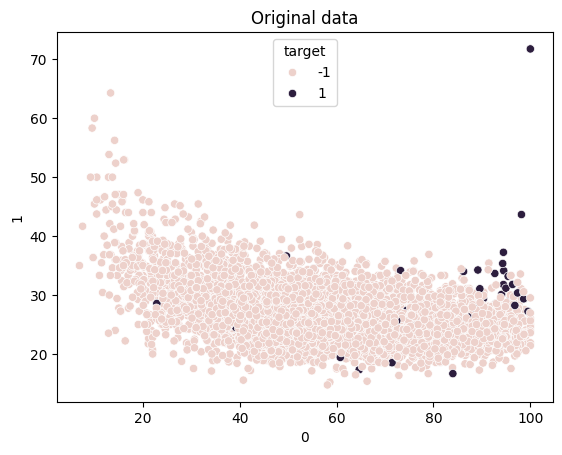

In [43]:
# original data

sns.scatterplot(data=X_train,
                x="0",
                y="1",
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Undersampled data')

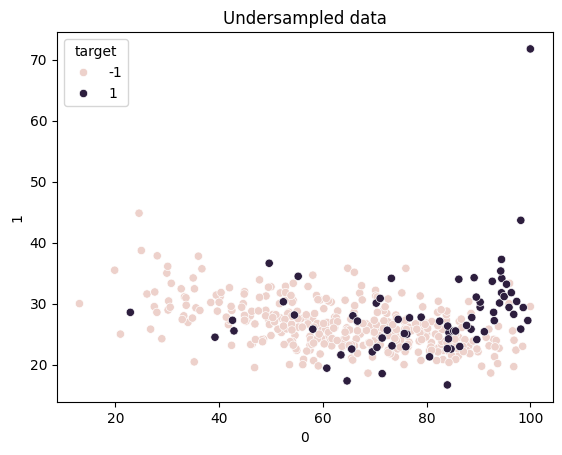

In [44]:
# undersampled data

sns.scatterplot(data=X_resampled,
                x="0",
                y="1",
                hue=y_resampled)

plt.title('Undersampled data')

Text(0.5, 1.0, 'Original data')

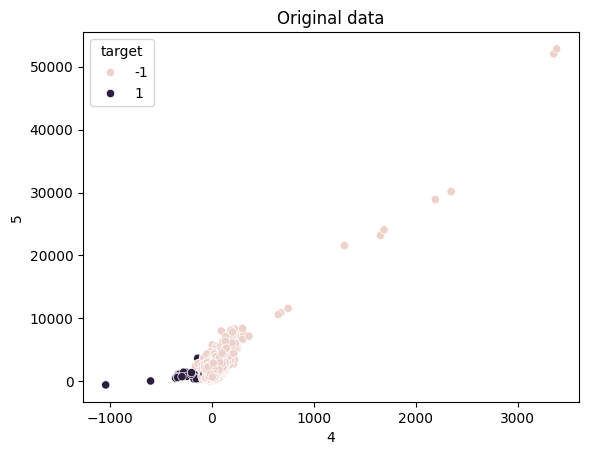

In [45]:
# original data

sns.scatterplot(data=X_train,
                x="4",
                y="5",
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Undersampled data')

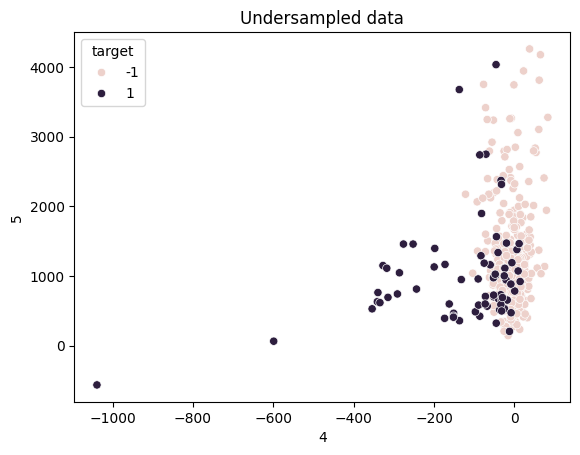

In [46]:
sns.scatterplot(data=X_resampled,
                x="4",
                y="5",
                hue=y_resampled)

plt.title('Undersampled data')

## Machine learning performance comparison

Let's compare model performance with and without undersampling.

In [47]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [48]:
# evaluate performance of algorithm built
# using imbalanced dataset

run_randomForests(X_train,
                  X_test,
                  y_train,
                  y_test)

Train set
Random Forests roc-auc: 0.9958521779574031
Test set
Random Forests roc-auc: 0.9565656565656565


In [49]:
# evaluate performance of algorithm built
# using undersampled dataset

run_randomForests(X_resampled,
                  X_test,
                  y_resampled,
                  y_test)

Train set
Random Forests roc-auc: 0.9993459526008003
Test set
Random Forests roc-auc: 0.9580359147025814


Performance seemed to increase quite a bit.

**HOMEWORK**

- Try changing the number of neighbours used to select the observations from the majority class and with different machine learning models. Compare final dataset size, model performance and the distributions of the observations before and after the undersampling.

Use of this type of data generation
- Medical Diagnosis: Simulating scenarios where two classes (e.g., benign and malignant tumors) are not perfectly separable.

- Finance: Predicting whether a transaction is fraudulent or not, where the classes may overlap due to noise and variability in transaction data.

- Manufacturing: Classifying products as defective or non-defective based on measurements, where noise can represent measurement errors or variations in the manufacturing process. Ex: Identifying defective automotive parts based on measurements such as dimensions, weight, and material properties.

- Marketing: Segmenting customers into different groups based on purchasing behavior, where noise can represent variations in customer behavior. Ex:Segmenting customers into different groups based on purchasing behavior, such as frequency of purchases, average transaction value, and product categories

- Environmental Science: Classifying different types of land cover (e.g., forest, urban) in satellite images, where noise can represent variations in image quality or environmental conditions.
